In [1]:
import numpy as np 
import SC_search
import matplotlib.pyplot as plt
import scienceplots 
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.style.use('science')

2024-03-13 15:46:07,180:default:WARNING:postprocessing:21 : Cannot import ligo.skymap. Skymaps will not be produced.
2024-03-13 15:46:07,182:default:WARNING:postprocessing:27 : Cannot import astropy_healpix. Will not be able to compute sky contours.


No CuPy or GPU response available.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU PhenomHM module.


In [2]:
# Frequency domain setup
year_in_seconds = 365.25*24*60*60

# Frequency bounds
f_low = 0.018
f_high = 0.03



T_obs = (3*year_in_seconds)
d = 1/(T_obs)
safety = 10
cadence = 2/(f_high*safety)

freqs = np.arange(0.015,f_high+d,d)


In [3]:
# Balrog setup


engine = {"name": "albertos",
  "Frequency_mode": False,      
  "NoiseCurve": "SciRD",       
  "TDIType": "Michelson",         
  "SUAkmax": 0,              
  "AmplitudeCorrOrder": 0}

lisa_config={"Cadence": cadence,#cadence,  # seconds
	     "Duration": T_obs, #315360000.0          # seconds
	     "Armlength": 2.5e+9,            # metres
	     "InitialRotation": 0.0,         # radians
	     "InitialPosition": 0.0,         # radians
	     "SunDistance": 1.0}


In [4]:
# Input parameters 
inc = 2.498091544796509
psi = -1.851592653589793

params_truth = [36.,#m1 [sm]
	  29.,#m2 [sm]
	  150.1*(1.e+6),#D
	  np.pi/4,#beta [rads]
	  2.01,#lambda [rads]
	  inc,#2.498091544796509,#inc [rads]
	  psi,#np.pi/4,#polarization [rads],
	  0,#phi0 [rads]
	  f_low/2,
	  0.01]#e0    ]

# Polarization shift due to convention difference between balrog and BBHx

params_truth_BBHx = [36.,#m1 [sm]
	  29.,#m2 [sm]
	  150.1*(1.e+6),#D
	  np.pi/4,#beta [rads]2.
	  2.01,#lambda [rads]
	  inc,#inc [rads]
	  -psi+np.pi/2,#np.pi/4,#polarization [rads], (Equivalent to shifting between the polarisation conventions) 
	  0,#phi0 [rads]
	  f_low/2,
	  0.01]#e0 ]


In [5]:
# Compute Balrog and BBHx responses on the full FFT grid 
signal_balrog= SC_search.Waveforms.TaylorF2Ecc.balrog_response(params_truth,
                                                                   freqs,
                                                                   f_high,
                                                                   T_obs,
                                                                   engine,
                                                                   'Michelson',
                                                                   logging=True)
signal_BBHx_direct= SC_search.Waveforms.TaylorF2Ecc.BBHx_response_direct(params_truth_BBHx,
                                                                         freqs,
                                                                         f_high,
                                                                         T_obs,
                                                                         'AET',
                                                                         logging=True)




Time to merger is:  3.555093774253596  years
Upper bound on time in band:  2.6438861012726442  years (no eccentricity evolution assumed)
Time to merger is:  3.555093774253596  years
Upper bound on time in band:  2.6438861012726442  years (no eccentricity evolution assumed)


In [6]:
# Use interpolation functionality from BBHx
freqs_sparse = freqs[::1000]
signal_BBHx_interpolated= SC_search.Waveforms.TaylorF2Ecc.BBHx_response_interpolate_CPU(params_truth_BBHx,
                                                                                  freqs_sparse,
                                                                                  freqs,
                                                                                  f_high,
                                                                                  T_obs,
                                                                                  'AET',
                                                                                  logging=True)



Time to merger is:  3.555093774253596  years
Upper bound on time in band:  2.6438861012726442  years (no eccentricity evolution assumed)


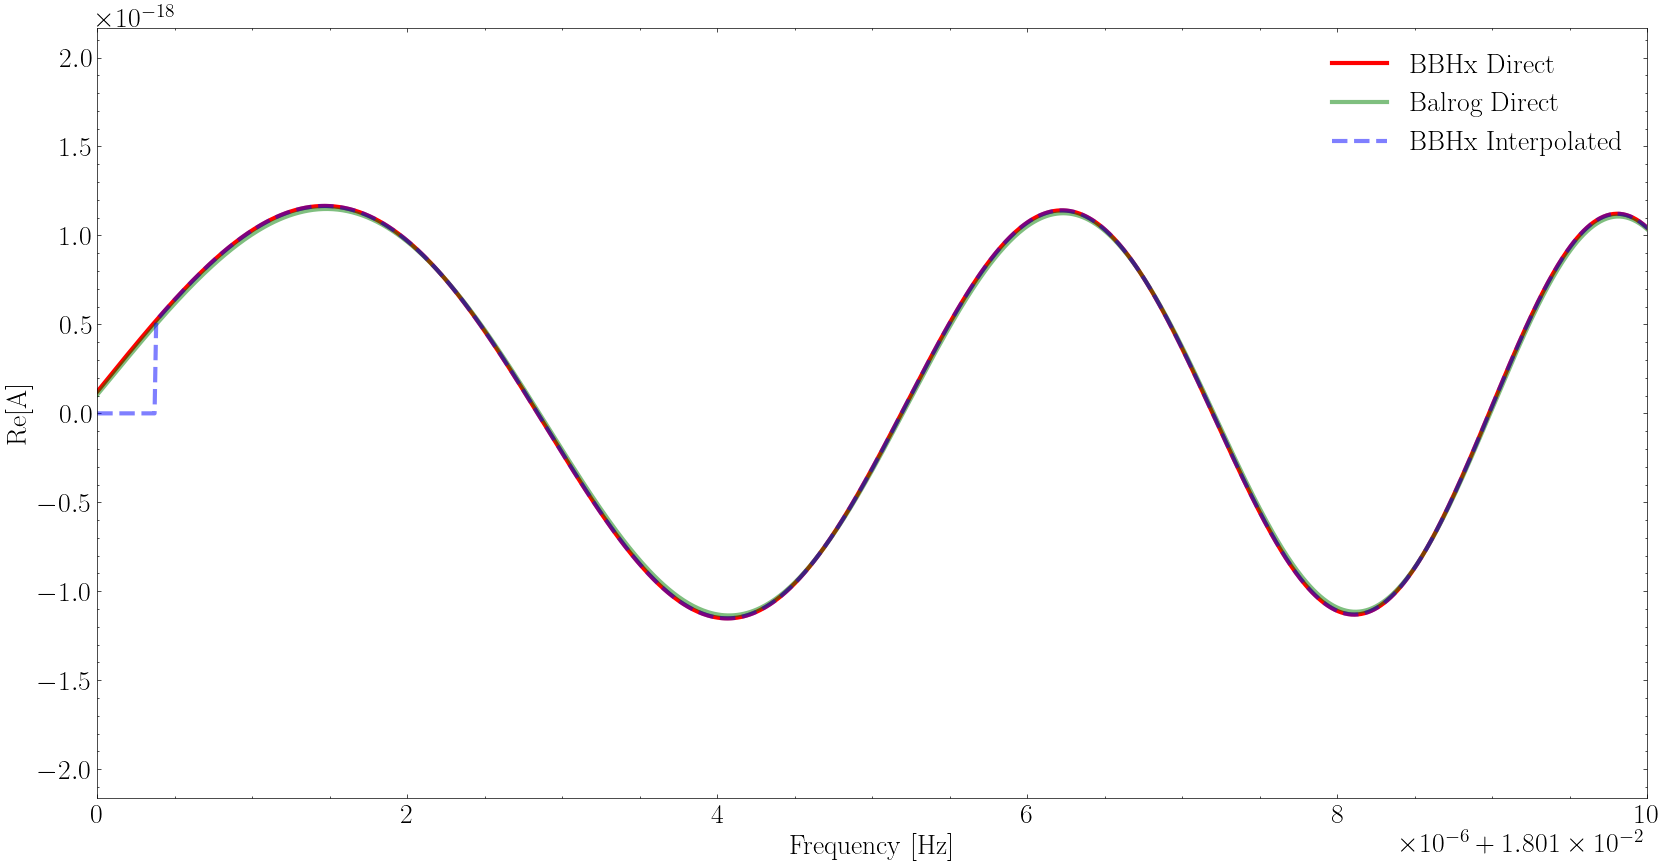

In [7]:
plt.figure(figsize=(20,10))
plt.plot(freqs,np.real(signal_BBHx_direct[0,:]),color='r',label='BBHx Direct',lw=3)
plt.plot(freqs,np.real(signal_balrog[0,:]),alpha=0.5,color='g',label='Balrog Direct',lw=3)
plt.plot(freqs,np.real(signal_BBHx_interpolated[0,:]),alpha=0.5,color='b',label='BBHx Interpolated',linestyle='--',lw=3)

plt.legend()
plt.xlim(0.01801,0.01802)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Re[A]')
plt.show()


In [10]:
# Compute an overlap to verify the similarity between BBHx and Balrog response codes

# Generate PSDs
Sdisp = SC_search.Noise.Sdisp_SciRD(freqs)
Sopt = SC_search.Noise.Sopt_SciRD(freqs)
psd_A = SC_search.Noise.psd_AEX(freqs,Sdisp,Sopt)
psd_E = SC_search.Noise.psd_AEX(freqs,Sdisp,Sopt)
psd_T = SC_search.Noise.psd_TX(freqs,Sdisp,Sopt)

psd_array = np.array([psd_A,psd_E,psd_T])


print('Overlap between BBHx and Balrog (Both on FFT grid): ',SC_search.Utility.match(signal_balrog,signal_BBHx_direct,d,psd_array))
print('Overlap between BBHx (FFT) and BBHx (Interpolated): ',SC_search.Utility.match(signal_BBHx_direct,signal_BBHx_interpolated,d,psd_array))
print('Overlap between Balrog (FFT) and BBHx (Interpolated): ',SC_search.Utility.match(signal_balrog,signal_BBHx_interpolated,d,psd_array))

Overlap between BBHx and Balrog (Both on FFT grid):  0.9954226296973734
Overlap between BBHx (FFT) and BBHx (Interpolated):  0.9989370249367583
Overlap between Balrog (FFT) and BBHx (Interpolated):  0.9943409420879136
